### Getting started

Each simulation needs three ingredients:

1. An Array object, which encodes the detectors' positions and their sensitivity to different frequencies.
2. A Pointing object, which determines how the array samples the sky. 
3. A Site object, which determines e.g. the atmospheric conditions and the array's earth-relative position. 

Let's use some of `maria`'s predefined defaults. Here's how we would set up a [MUSTANG-2](https://greenbankobservatory.org/science/gbt-observers/mustang-2/) simulation staring at the zenith for ten minutes:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import maria 
from maria import models

mustang_2 = maria.get_array("AtLAST")
daisy_scan = maria.get_pointing("STARE_0az_90el_60s")
green_bank = maria.get_site("APEX")

We can combine these objects into a total model. An efficient, lightweight model is the linear angular model, which we'll use to simulate the sky temperature at 90 and 150 GHz.

In [2]:
lam = maria.models.LinearAngularModel(array=mustang_2, pointing=daisy_scan, site=green_bank)

lam.simulate_temperature(units='K_RJ')

print(lam.temperature.shape)

Sampling layers: 100%|██████████| 8/8 [00:00<00:00, 12.49it/s]


(600, 1200)


The simulated time-ordered data is stored `lam.temperature`, which has shape `(n_freqs, n_dets, n_samples)`. Plotting the output as fluctuations:

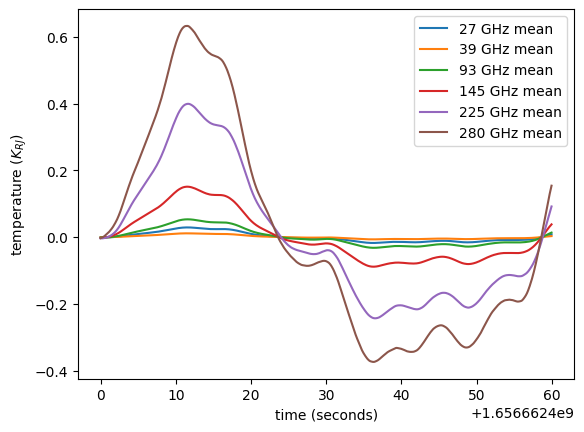

In [4]:
for uib, uband in enumerate(np.unique(lam.array.band)):

    band_mask = lam.array.band == uband
    band_mean = lam.temperature[band_mask].mean(axis=0)
    plt.plot(lam.pointing.unix, band_mean - band_mean.mean(), label=f'{1e-9*uband:.00f} GHz mean')

plt.xlabel('time (seconds)')
plt.ylabel(r'temperature ($K_{RJ}$)')
plt.legend()